# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

In [2]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [3]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [4]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

C:\Users\Jack\AppData\Local\Temp\ipykernel_4044\1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [5]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [6]:
# minimum and maximum values for age, yredu, capgain, caploss and workhr
min_max = df[['age', 'yredu', 'capgain', 'caploss', 'workhr']].agg([min, max])
print(min_max)

# normalize the data
df[['age', 'yredu', 'capgain', 'caploss', 'workhr']] = df[['age', 'yredu', 'capgain', 'caploss', 'workhr']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df[:3] # show the first 3 records


     age  yredu  capgain  caploss  workhr
min   17      1        0        0       1
max   90     16    99999     4356      99


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [7]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


Numpy works nicely with pandas, like below:

In [8]:
np.sum(subdf["caploss"])

652.5941230486685

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [9]:
percentage_male = sum(df["sex"] == " Male") / len(df)
percentage_female = sum(df["sex"] == " Female") / len(df)

print(f"percentage of male: {100 * percentage_male:0.2f}%")
print(f"percentage of female: {100 * percentage_female:0.2f}%")

percentage of male: 66.92%
percentage of female: 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [10]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [11]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print(f"number of records with missing values: {len(df_with_missing)}")
print(f"percentage of records with missing values: {100 * len(df_with_missing) / len(df):0.2f}%")

number of records with missing values: 1843
percentage of records with missing values: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [12]:
print("All possible values for work are: ")
print(set(df_not_missing["work"]))

All possible values for work are: 
{' Self-emp-inc', ' State-gov', ' Without-pay', ' Private', ' Self-emp-not-inc', ' Federal-gov', ' Local-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [13]:
data = pd.get_dummies(df_not_missing)

In [14]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [15]:
print(f"number of columns: {len(data.columns)}")

number of columns: 57


**Answer**

The 57 columns comes from `pd.get_dummy()` one-hot encoding strings in the dataframe `data`. It appends a column for every possible value of a certain column and set the value to 1 if the value of the column is present or 0 otherwise. 

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [16]:
datanp = data.values.astype(np.float32)

In [17]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
    
    Returns:
        - a string, the categorical value name of the feature
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [18]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [19]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# split data into 70% training, 15% validation, and 15% testing
train_indices = np.random.choice(len(datanp), int(0.7 * len(datanp)), replace=False)
remaining = set(range(len(datanp))) - set(train_indices)
valid_indices = np.random.choice(list(remaining), int(0.5 * len(remaining)), replace=False)
test_indices = list(remaining - set(valid_indices))

train_data = datanp[train_indices]
valid_data = datanp[valid_indices]
test_data = datanp[test_indices]

print(f"number of training records: {len(train_data)}")
print(f"number of validation records: {len(valid_data)}")
print(f"number of testing records: {len(test_data)}")

number of training records: 21502
number of validation records: 4608
number of testing records: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [22]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "autoencoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 57),
            nn.ReLU(),
            nn.Linear(57, 37),
            nn.ReLU(),
            nn.Linear(37, 25)
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 37),
            nn.ReLU(),
            nn.Linear(37, 57),
            nn.ReLU(),
            nn.Linear(57, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**Answer**

The data frame `data` contains only 1's and 0's for the features because it has been 1-hot-encoded. Therefore we expect the output of the autoencoder to have the values between 0 and 1, and the max in the softmax output will be the predicted value. 

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [41]:
import os

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("./csv/{}_train_acc.csv".format(path))
    val_err = np.loadtxt("./csv/{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("./csv/{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("./csv/{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def train(model, train_data, valid_data, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # record training, validation accuracy and loss
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_validation_loss = 0.0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            training_loss = criterion(recon, data)
            training_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += training_loss.item()
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            validation_loss = criterion(recon, data)
            total_validation_loss += validation_loss.item()
        train_loss[epoch] = float(total_train_loss) / batch_size
        val_loss[epoch] = float(total_validation_loss) / batch_size
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)
        os.makedirs("./models", exist_ok=True)
        model_path = f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"
        torch.save(model.state_dict(), "./models/"+model_path)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
                "Validation acc: {}, Validation loss: {}").format(
                     epoch + 1,
                     train_acc[epoch],
                     train_loss[epoch],
                     val_acc[epoch],
                     val_loss[epoch]))
    os.makedirs("./csv", exist_ok=True)
    np.savetxt("./csv/{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("./csv/{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("./csv/{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("./csv/{}_val_loss.csv".format(model_path), val_loss)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [21]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train acc: 0.5337953058630205, Train loss: 0.4519631272414699 |Validation acc: 0.5335648148148148, Validation loss: 0.06433742330409586
Epoch 2: Train acc: 0.5897280873097076, Train loss: 0.27271649666363373 |Validation acc: 0.5872395833333334, Validation loss: 0.054865033423993737
Epoch 3: Train acc: 0.5951306855176263, Train loss: 0.24186828645179048 |Validation acc: 0.5930989583333334, Validation loss: 0.047291941416915506
Epoch 4: Train acc: 0.6020835271137569, Train loss: 0.20190150212147273 |Validation acc: 0.599609375, Validation loss: 0.03898006092640571
Epoch 5: Train acc: 0.6064552134685146, Train loss: 0.17209649458527565 |Validation acc: 0.6006582754629629, Validation loss: 0.03453038170118816
Epoch 6: Train acc: 0.6138808792980498, Train loss: 0.15229142454336397 |Validation acc: 0.6078197337962963, Validation loss: 0.03115456792875193
Epoch 7: Train acc: 0.6128112113601836, Train loss: 0.13749105177703314 |Validation acc: 0.6071325231481481, Validation loss: 0.02

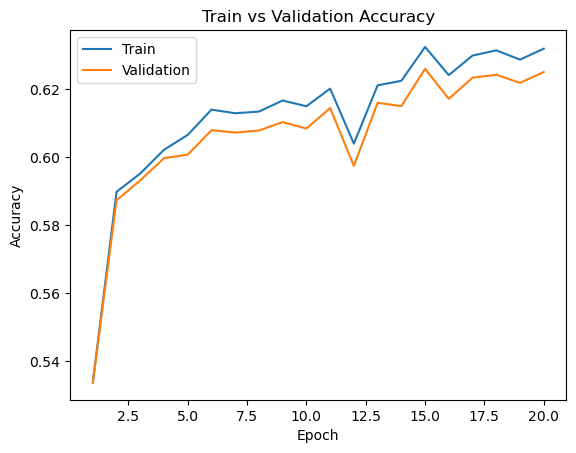

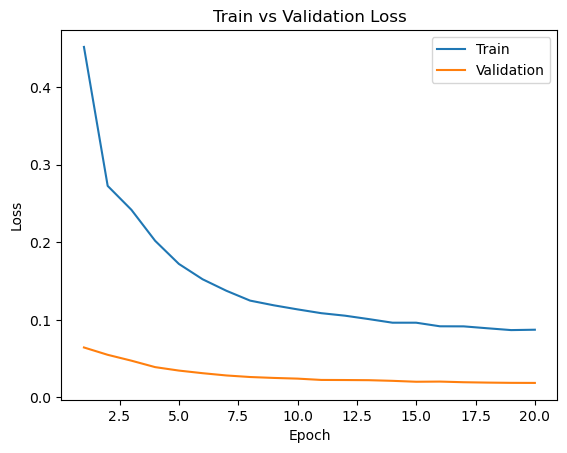

In [43]:
model = AutoEncoder()
batch_size = 64
learning_rate = 8 * 1e-4
epoch = 20
train(model, train_data, valid_data, batch_size=batch_size, num_epochs=epoch, learning_rate=learning_rate)
plot_training_curve(f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch-1}")

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

### Model 1

Batch size = 64

num_epochs = 20

learning_rate = 0.01

Changing the learning rate seem to had improved accuracy while decreasing loss, so I will try to overshoot the learning_rate in the next model

In [44]:
# model 1
model1 = AutoEncoder()
train(model1, train_data, valid_data, batch_size=64, num_epochs=20, learning_rate=0.01)

Epoch 1: Train acc: 0.5977428456267634, Train loss: 0.29093484161421657 |Validation acc: 0.5946180555555556, Validation loss: 0.04232599804527126
Epoch 2: Train acc: 0.6145862400396862, Train loss: 0.16688810809864663 |Validation acc: 0.6082175925925926, Validation loss: 0.030888893496012315
Epoch 3: Train acc: 0.6074783741047345, Train loss: 0.12907178114983253 |Validation acc: 0.6012369791666666, Validation loss: 0.024822176404995844
Epoch 4: Train acc: 0.6220506619539268, Train loss: 0.11111684959905688 |Validation acc: 0.6169704861111112, Validation loss: 0.022000797966029495
Epoch 5: Train acc: 0.6074396180200291, Train loss: 0.10307411599205807 |Validation acc: 0.5993923611111112, Validation loss: 0.021867893272428773
Epoch 6: Train acc: 0.6285151768827706, Train loss: 0.09803075868694577 |Validation acc: 0.6218532986111112, Validation loss: 0.020418440661160275
Epoch 7: Train acc: 0.632716336464825, Train loss: 0.09480904116935562 |Validation acc: 0.6255063657407407, Validation 

### Model 2


Batch size = 64

num_epochs = 20

learning_rate = 0.02

We've definitly overshoot the learning rate. To compensate let's increase the batch_size to 128

In [46]:
model2 = AutoEncoder()
train(model2, train_data, valid_data, batch_size=64, num_epochs=20, learning_rate=0.02)

Epoch 1: Train acc: 0.5960143242489071, Train loss: 0.2756308935931884 |Validation acc: 0.5914713541666666, Validation loss: 0.0443211913225241
Epoch 2: Train acc: 0.6089433541065947, Train loss: 0.1817469539528247 |Validation acc: 0.6026475694444444, Validation loss: 0.036325656226836145
Epoch 3: Train acc: 0.599378352401327, Train loss: 0.1604621588194277 |Validation acc: 0.5971498842592593, Validation loss: 0.03304609446786344
Epoch 4: Train acc: 0.5981149040399343, Train loss: 0.1472805678495206 |Validation acc: 0.5886140046296297, Validation loss: 0.03112790684099309
Epoch 5: Train acc: 0.5934254177905931, Train loss: 0.13715647696517408 |Validation acc: 0.587890625, Validation loss: 0.028589203371666372
Epoch 6: Train acc: 0.6069745450035655, Train loss: 0.13587886074674316 |Validation acc: 0.6056857638888888, Validation loss: 0.028527893970021978
Epoch 7: Train acc: 0.5999364400210833, Train loss: 0.13209841086063534 |Validation acc: 0.5912181712962963, Validation loss: 0.028647

### Model 3


Batch size = 128

num_epochs = 20

learning_rate = 0.02

The change in batch_size didn't seem to have an effect. Let's decrease the learning rate back down to 0.01, and decrease batch size to 32 to compare the effect of the batch size

In [47]:
model3 = AutoEncoder()
train(model3, train_data, valid_data, batch_size=128, num_epochs=20, learning_rate=0.02)

Epoch 1: Train acc: 0.5903326822311102, Train loss: 0.09508018073393032 |Validation acc: 0.5889033564814815, Validation loss: 0.012558079353766516
Epoch 2: Train acc: 0.6094626856416457, Train loss: 0.054882050899323076 |Validation acc: 0.6064814814814815, Validation loss: 0.010643871850334108
Epoch 3: Train acc: 0.6191517068179704, Train loss: 0.04427874737302773 |Validation acc: 0.6118344907407407, Validation loss: 0.008545917109586298
Epoch 4: Train acc: 0.6156946640622578, Train loss: 0.03879015048732981 |Validation acc: 0.6077835648148148, Validation loss: 0.008118422338156961
Epoch 5: Train acc: 0.596657675255015, Train loss: 0.03624948862125166 |Validation acc: 0.5902416087962963, Validation loss: 0.007706303091254085
Epoch 6: Train acc: 0.6073466034167364, Train loss: 0.032956427938188426 |Validation acc: 0.5985604745370371, Validation loss: 0.007130713915103115
Epoch 7: Train acc: 0.6140126499860478, Train loss: 0.030685573161463253 |Validation acc: 0.6074942129629629, Validat

### Model 4

Batch size = 32

num_epochs = 20

learning_rate = 0.01

Decreasing batch size seem to had an inverse effect on the training.


In [49]:
model4 = AutoEncoder()
train(model4, train_data, valid_data, batch_size=32, num_epochs=20, learning_rate=0.01)

Epoch 1: Train acc: 0.6062924379127523, Train loss: 0.9471679113339633 |Validation acc: 0.6007306134259259, Validation loss: 0.13968103018123657
Epoch 2: Train acc: 0.6164620345394227, Train loss: 0.5934513091342524 |Validation acc: 0.6085431134259259, Validation loss: 0.12028374196961522
Epoch 3: Train acc: 0.611950826279726, Train loss: 0.523720977071207 |Validation acc: 0.6060112847222222, Validation loss: 0.10861348488833755
Epoch 4: Train acc: 0.6097107245837596, Train loss: 0.48414630169281736 |Validation acc: 0.6021050347222222, Validation loss: 0.10337445529876277
Epoch 5: Train acc: 0.6158729420519021, Train loss: 0.4524262000923045 |Validation acc: 0.6075303819444444, Validation loss: 0.0917995320778573
Epoch 6: Train acc: 0.6293910643971103, Train loss: 0.4291014522896148 |Validation acc: 0.6233723958333334, Validation loss: 0.08752209602971561
Epoch 7: Train acc: 0.6307475273617958, Train loss: 0.4189704133605119 |Validation acc: 0.6219256365740741, Validation loss: 0.08692

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [50]:
best_model = AutoEncoder()
best_model_path = "./models/model_AutoEncoder_bs64_lr0.01_epoch19"
best_model.load_state_dict(torch.load(best_model_path))

test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
print("Final Test Accuracy: {}".format(get_accuracy(best_model, test_loader)))

Final Test Accuracy: 0.6575882523148148


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [57]:
most_common = {}
for col in df_not_missing:
    most_common[col] = df_not_missing[col].value_counts().idxmax()

In [58]:
most_common

{'age': 0.2602739726027397,
 'yredu': 0.5333333333333333,
 'capgain': 0.0,
 'caploss': 0.0,
 'workhr': 0.3979591836734694,
 'work': ' Private',
 'marriage': ' Married-civ-spouse',
 'occupation': ' Prof-specialty',
 'edu': ' HS-grad',
 'relationship': ' Husband',
 'sex': ' Male'}

In [61]:
baseline_acc = sum(df_not_missing["marriage"] == most_common["marriage"]) / len(df_not_missing)
print(f"Baseline Accuracy: {100*baseline_acc:.3f}%")

Baseline Accuracy: 46.679%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**Answer**

The test accuracy of the autoencoder is 65.75%, which is much higher than the baseline accuracy of 45.679%

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [63]:
get_features(test_data[0])

{'work': 'Local-gov',
 'marriage': 'Never-married',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Own-child',
 'sex': 'Female'}

**Answer**

Personally won't had gotten the education level, since I would assume that this person would have a masters or a PhD to be a professor. So by extension I'd assume it would be hard for others to guess as well.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [64]:
test_sample = zero_out_feature(test_data[0:1], "edu")[0]
prediction = best_model(torch.from_numpy(test_sample))
get_feature(prediction.detach().numpy(), "edu")

'Bachelors'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [65]:
most_common["edu"]

' HS-grad'